In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import multiprocessing

In [2]:
'''
Creating a runge kutta 2 routine for a damped driven pendulum
''' 
def rk2( F_D, omega, theta, dt = 0.04, g = 9.8 , l = 9.8, q = 1/2, omega_D = 2/3, tme =[0], stoptime=60): 
    #requires an array with starting values for theta and omega and a values for driving force. Has additional parameters that can be changed
    
    i=1
    while tme[-1] < stoptime:
        
        k1 = -(g/l)*np.sin(theta[i-1])-q*omega[i-1]+F_D*np.sin(omega_D*tme[i-1])
        k2 = -(g/l)*np.sin(theta[i-1])-q*(omega[i-1]+1/2*k1*dt)+F_D*np.sin(omega_D*(tme[i-1]+1/2*dt))
        
        omega_new = omega[i-1] + k2 * dt             #Where RK2 is actually implemented
        omega = np.append(omega, omega_new) 

        theta_new = theta[i-1]+omega_new*dt
        theta_new = (theta_new + np.pi) % (2 * np.pi) - np.pi #so we stay on [-pi,pi]
            
        theta = np.append(theta, theta_new)

        tme = np.append(tme,tme[i-1]+dt)

        i+=1
        
    return(omega, theta, tme)

In [3]:
'''
Creating a runge kutta 2 routine for a damped driven pendulum with fewer arrays to run faster in the bifurcation routine
''' 
def rk2_bif( F_D, omega, theta, dt = 0.04, g = 9.8 , l = 9.8, q = 1/2, omega_D = 2/3, tme = 0, stoptime=300): 
    #requires starting values for theta and omega and a values for driving force. Has additional parameters that can be changed
    
    theta_raw = []
    t_sample = np.arange(50*(2*np.pi)/omega_D,stoptime,(2*np.pi)/omega_D)
    tme_raw = []
    while tme < stoptime:

        k1 = -(g/l)*np.sin(theta)-q*omega+F_D*np.sin(omega_D*tme)
        k2 = -(g/l)*np.sin(theta)-q*(omega+1/2*k1*dt)+F_D*np.sin(omega_D*(tme+1/2*dt))
        
        omega += k2 * dt

        theta_new = theta + omega*dt
        theta_new = (theta_new + np.pi) % (2 * np.pi) - np.pi #so we stay on [-pi,pi]  
        
        theta = theta_new
        tme += dt
        tme_raw = np.append(tme_raw, tme)            #Gives raw list of times

        theta_raw = np.append(theta_raw, theta)      #Gives raw list of thetas 
            
    theta_interp = interp1d(tme_raw, theta_raw, kind='quadratic', fill_value="extrapolate")   #Gives a new list extrapolating values between measured ones
    theta_unif = theta_interp(t_sample)  #gives a lew list as the sample times, this is so I can put any values dt and not worry about how they line up             
    
    forcelist = np.full((1,len(theta_unif)),F_D)   #Gives a list of forces that is as long as thetas, but full of just the force used (for easy graphing)
    return(theta_unif,forcelist)

Reproducing plots from textbook fig. 3.6:

In [4]:
#Getting values for 0, 0.5, and 1.2 driving forces
omega0, theta0, tme0 = rk2(0, omega = [0],theta = [0.2])
omega05, theta05, tme05 = rk2(0.5, omega = [0],theta = [0.2])
omega12, theta12, tme12 = rk2(1.2, omega = [0],theta = [0.2])


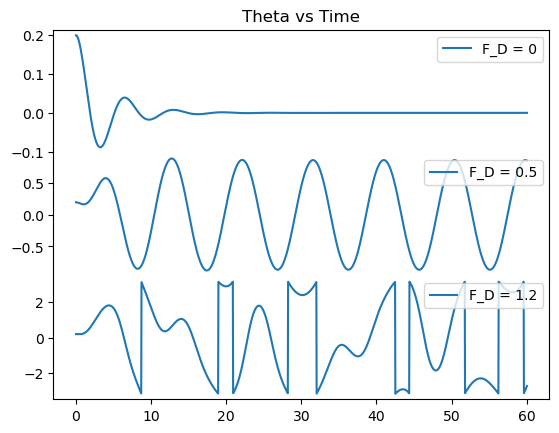

In [5]:
#just plotting here

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False)


ax1.plot(tme0, theta0, label = "F_D = 0")
ax1.set_title('Theta vs Time')
ax1.spines['bottom'].set_visible(False)
ax1.legend()


ax2.plot(tme05, theta05,label = "F_D = 0.5")
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.legend(loc = 1)

ax3.plot(tme12, theta12,label = "F_D = 1.2")
ax3.spines['top'].set_visible(False)
ax3.legend(loc = 1)

f.subplots_adjust(hspace=0)
#plt.savefig("Theta vs Time")

#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

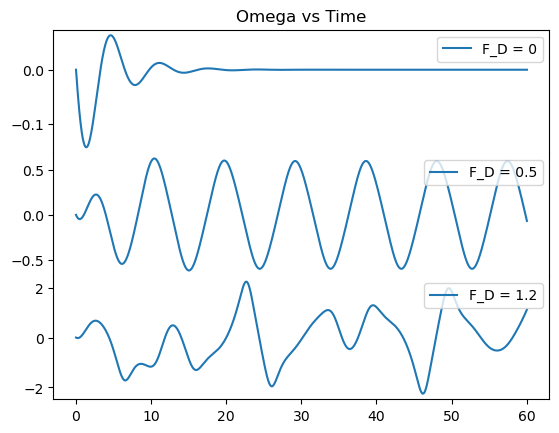

In [6]:
#Just plotting here
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False)

ax1.plot(tme0, omega0, label = "F_D = 0")
ax1.set_title('Omega vs Time')
ax1.spines['bottom'].set_visible(False)
ax1.legend(loc = 1)

ax2.plot(tme05, omega05,label = "F_D = 0.5")
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.legend(loc = 1)

ax3.plot(tme12, omega12,label = "F_D = 1.2")
ax3.spines['top'].set_visible(False)
ax3.legend(loc = 1)

f.subplots_adjust(hspace=0)
#plt.savefig("Omega vs Time")

Reproducing plots from textbook fig 3.9:

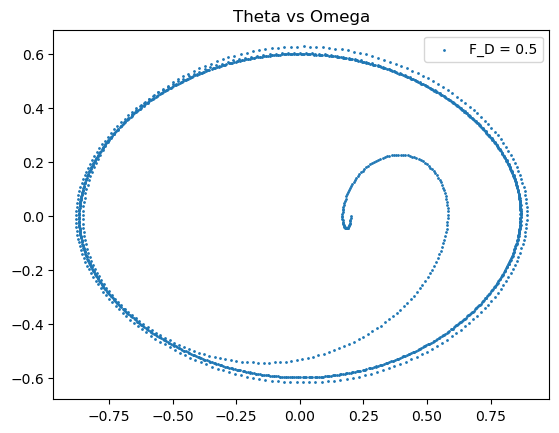

In [7]:
plt.scatter(theta05,omega05,label='F_D = 0.5',s=1)
plt.title('Theta vs Omega')
plt.legend()
#plt.savefig("Theta vs Omega F_D = low")
plt.show()


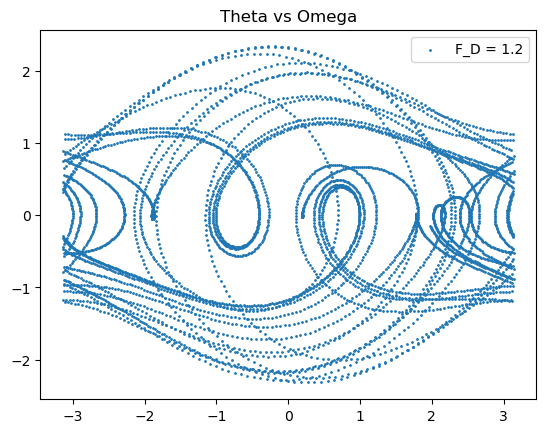

In [8]:
#Still force = 1.2 but increased stop time so it's prettier
omega12, theta12, tme12 = rk2(1.2, omega = [0],theta = [0.2],stoptime = 200)
plt.scatter(theta12,omega12,label='F_D = 1.2',s=1)
plt.title('Theta vs Omega')
plt.legend()
#plt.savefig('Theta vs Omega F_D = high')
plt.show()


In [11]:
%%time
'''
This is just to get a bunch of runs through this range of driving forces

it took 6min 28s to run this with these values - these parameters take 4m 10s to run on my other bifurcation code below
'''

F = np.arange(1.4,1.41,0.0001)
thetalist=[]
forcelist = []
for x in F:
    thetabif,forcebif = rk2_bif(x, 0,0.2,dt = 0.005, stoptime = 600)
    forcelist.extend(forcebif)
    thetalist.extend(thetabif)



KeyboardInterrupt: 

In [ ]:
plt.scatter(forcelist,thetalist,s=.5,color = 'black')


Copy and paste the code below into a pure python file/vscode/other system like that and run it if you want the bifurcation diagram to be faster to generate.

Warning: it uses all the CPU's(-1) in your computer at once so as long as you're ok with that :) 

In [ ]:
#This uses dt = 0.005, stoptime = 600 driving force 1.35 to 1.5 by steps of 0.0001, takes 2.7 hours to run
#I am too scared to try these values on the regular program above.
#The more intensive you make the calculations the better this code works to cut down the time.

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import multiprocessing
import time

def rk2_bif( F_D, omega, theta, dt = 0.04, g = 9.8 , l = 9.8, q = 1/2, omega_D = 2/3, tme = 0, stoptime=120): 
    #requires starting values for theta and omega and a values for driving force. Has additional parameters that can be changed
    
    theta_raw = []
    t_sample = np.arange(50*(2*np.pi)/omega_D,stoptime,(2*np.pi)/omega_D)
    tme_raw = []
    while tme < stoptime:

        k1 = -(g/l)*np.sin(theta)-q*omega+F_D*np.sin(omega_D*tme)
        k2 = -(g/l)*np.sin(theta)-q*(omega+1/2*k1*dt)+F_D*np.sin(omega_D*(tme+1/2*dt))
        
        omega += k2 * dt

        theta_new = theta + omega*dt
        theta_new = (theta_new + np.pi) % (2 * np.pi) - np.pi #so we stay on [-pi,pi]  
        
        theta = theta_new
        tme += dt
        tme_raw = np.append(tme_raw, tme)

        theta_raw = np.append(theta_raw, theta)
            
    theta_interp = interp1d(tme_raw, theta_raw, kind='quadratic', fill_value="extrapolate")
    theta_unif = theta_interp(t_sample)   
    
    forcelist = np.full((1,len(theta_unif)),F_D)    
    return(theta_unif,forcelist)


def split_bifurcation(i, total_chunks):
    F_M = np.arange(1.35, 1.50, 0.0001)
    chunk_size = len(F_M) // total_chunks
    start = i * chunk_size
    end = (i + 1) * chunk_size if i != total_chunks - 1 else len(F_M)
    segment = F_M[start:end]

    thetalist = []
    forcelist = []

    for x in segment:
        thetabif, forcebif = rk2_bif(x, 0, 0.2, dt=0.005, stoptime=600)
        forcelist = np.append(forcelist, forcebif)
        thetalist = np.append(thetalist, thetabif)

    return thetalist, forcelist


if __name__ == "__main__":
    start = time.time()
    Core_Number = multiprocessing.cpu_count()-1
    args = [(i, Core_Number) for i in range(Core_Number)]
    
    thetalist_M=[]
    forcelist_M = []
    
    with Pool() as pool:
        results = pool.starmap(split_bifurcation, args)


    for theta, force in results:
        thetalist_M.extend(theta)
        forcelist_M.extend(force)

    end = time.time()
    print(f"Execution time: {end - start:.2f} seconds")   

    plt.scatter(forcelist_M,thetalist_M,s=.5,color = 'black')
    plt.ylim(0.8,3.14)
    plt.show()


